# Python Numerical Tools

## 4. scipy

The scipy package contains various toolboxes dedicated to common issues in scientific computing. Its different submodules correspond to different applications, such as interpolation, integration, optimization, image processing, statistics, special functions, etc.

scipy is the core package for scientific routines in Python; it is meant to operate efficiently on numpy arrays, so that numpy and scipy work hand in hand.

Before implementing a routine, it is worth checking if the desired data processing is not already implemented in Scipy. Scipy’s routines are optimized and tested, and should therefore be used when possible.


### Linear algebra operations: scipy.linalg

The scipy.linalg module provides standard linear algebra operations, relying on an underlying efficient implementation (BLAS, LAPACK).

#### The scipy.linalg.det() function computes the determinant of a square matrix:

In [1]:
import numpy as np
from scipy import linalg

arr = np.array([[1, 2],
                [3, 4]])
linalg.det(arr)

-2.0

In [2]:
arr = np.array([[3, 2],
                [6, 4]])
linalg.det(arr) 

0.0

In [3]:
linalg.det(np.ones((3, 4)))

ValueError: expected square matrix

#### The scipy.linalg.inv() function computes the inverse of a square matrix:

In [4]:
arr = np.array([[1, 2],
                [3, 4]])
iarr = linalg.inv(arr)
iarr

array([[-2. ,  1. ],
       [ 1.5, -0.5]])

In [5]:
np.allclose(np.dot(arr, iarr), np.eye(2))

True

Finally computing the inverse of a singular matrix (its determinant is zero) will raise LinAlgError:

In [6]:
arr = np.array([[3, 2],
                [6, 4]])
linalg.inv(arr)

LinAlgError: singular matrix

More advanced operations are available, for example singular-value decomposition (SVD):

In [7]:
arr = np.arange(9).reshape((3, 3)) + np.diag([1, 0, 1])
uarr, spec, vharr = linalg.svd(arr)

In [8]:
uarr

array([[-0.1617463 , -0.98659196,  0.02178164],
       [-0.47456365,  0.09711667,  0.87484724],
       [-0.86523261,  0.13116653, -0.48390895]])

In [9]:
spec

array([14.88982544,  0.45294236,  0.29654967])

In [10]:
vharr

array([[-0.45513179, -0.54511245, -0.70406496],
       [ 0.20258033,  0.70658087, -0.67801525],
       [-0.86707339,  0.45121601,  0.21115836]])

The original matrix can be re-composed by matrix multiplication of the outputs of svd with np.dot:

In [11]:
sarr = np.diag(spec)
svd_mat = uarr@sarr@vharr
svd_mat

array([[1., 1., 2.],
       [3., 4., 5.],
       [6., 7., 9.]])

In [12]:
arr

array([[1, 1, 2],
       [3, 4, 5],
       [6, 7, 9]])

In [13]:
np.allclose(svd_mat, arr)

True

SVD is commonly used in statistics and signal processing. Many other standard decompositions (QR, LU, Cholesky, Schur), as well as solvers for linear systems, are available in scipy.linalg.

### Interpolation: scipy.interpolate

scipy.interpolate is useful for fitting a function from experimental data and thus evaluating points where no measure exists. The module is based on the FITPACK Fortran subroutines.

By imagining experimental data close to a sine function:

In [14]:
measured_time = np.linspace(0, 1, 10)
noise = (np.random.random(10)*2 - 1) * 1e-1
measures = np.sin(2 * np.pi * measured_time) + noise

scipy.interpolate.interp1d can build a linear interpolation function:

In [15]:
from scipy.interpolate import interp1d
linear_interp = interp1d(measured_time, measures)

Then the result can be evaluated at the time of interest:

In [16]:
interpolation_time = np.linspace(0, 1, 50)
linear_results = linear_interp(interpolation_time)

A cubic interpolation can also be selected by providing the kind optional keyword argument:

In [17]:
cubic_interp = interp1d(measured_time, measures, kind='cubic')
cubic_results = cubic_interp(interpolation_time)

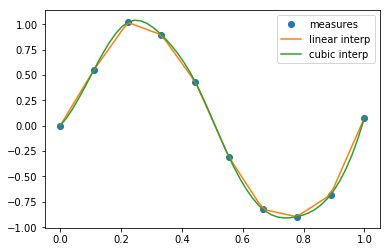

In [19]:
from matplotlib import pyplot as plt
plt.figure(figsize=(6, 4))
plt.plot(measured_time, measures, 'o', ms=6, label='measures')
plt.plot(interpolation_time, linear_results, label='linear interp')
plt.plot(interpolation_time, cubic_results, label='cubic interp')
plt.legend()
plt.show()

scipy.interpolate.interp2d is similar to scipy.interpolate.interp1d, but for 2-D arrays. Note that for the interp family, the interpolation points must stay within the range of given data points.

### Optimization and fit: scipy.optimize

Optimization is the problem of finding a numerical solution to a minimization or equality.

The scipy.optimize module provides algorithms for function minimization (scalar or multi-dimensional), curve fitting and root finding.

#### Curve fitting

Suppose we have data on a sine wave, with some noise:

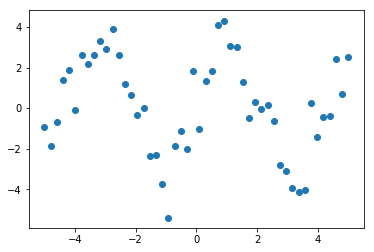

In [20]:
# First generate some data

import numpy as np

# Seed the random number generator for reproducibility
np.random.seed(0)

x_data = np.linspace(-5, 5, num=50)
y_data = 2.9 * np.sin(1.5 * x_data) + np.random.normal(size=50)

# And plot it
import matplotlib.pyplot as plt
plt.figure(figsize=(6, 4))
plt.scatter(x_data, y_data)

plt.show()

If we know that the data lies on a sine wave, but not the amplitudes or the period, we can find those by least squares curve fitting. First we have to define the test function to fit, here a sine with unknown amplitude and period:

In [21]:
from scipy import optimize

def test_func(x, a, b):
    return a * np.sin(b * x)

params, params_covariance = optimize.curve_fit(test_func, x_data, y_data,
                                               p0=[2, 2])

print(params)

[3.05931973 1.45754553]


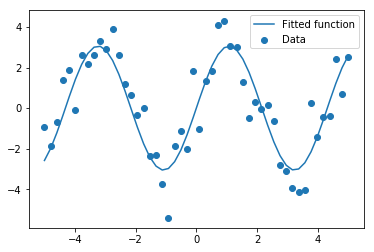

In [22]:
# And plot the resulting curve on the data

plt.figure(figsize=(6, 4))
plt.scatter(x_data, y_data, label='Data')
plt.plot(x_data, test_func(x_data, params[0], params[1]),
         label='Fitted function')

plt.legend(loc='best')

plt.show()

#### Curve fitting: temperature as a function of month of the year

We have the min and max temperatures in Alaska for each months of the year. We would like to find a function to describe this yearly evolution.

For this, we will fit a periodic function.


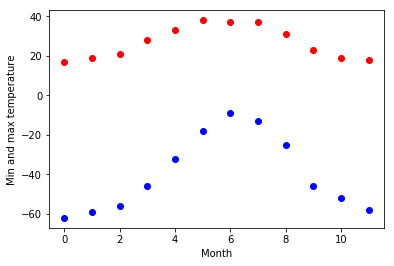

In [23]:
# The data

import numpy as np

temp_max = np.array([17,  19,  21,  28,  33,  38, 37,  37,  31,  23,  19,  18])
temp_min = np.array([-62, -59, -56, -46, -32, -18, -9, -13, -25, -46, -52, -58])

import matplotlib.pyplot as plt
months = np.arange(12)
plt.plot(months, temp_max, 'ro')
plt.plot(months, temp_min, 'bo')
plt.xlabel('Month')
plt.ylabel('Min and max temperature')

plt.show()

In [24]:
# Fitting it to a periodic function

from scipy import optimize
def yearly_temps(times, avg, ampl, time_offset):
    return (avg
            + ampl * np.cos((times + time_offset) * 2 * np.pi / times.max()))

res_max, cov_max = optimize.curve_fit(yearly_temps, months,
                                      temp_max, [20, 10, 0])
res_min, cov_min = optimize.curve_fit(yearly_temps, months,
                                      temp_min, [-40, 20, 0])

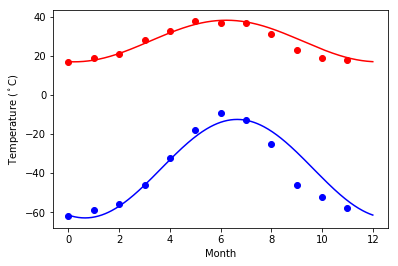

In [25]:
# Plotting the fit

days = np.linspace(0, 12, num=365)

plt.figure()
plt.plot(months, temp_max, 'ro')
plt.plot(days, yearly_temps(days, *res_max), 'r-')
plt.plot(months, temp_min, 'bo')
plt.plot(days, yearly_temps(days, *res_min), 'b-')
plt.xlabel('Month')
plt.ylabel('Temperature ($^\circ$C)')

plt.show()

#### Finding the minimum of a scalar function

Let’s define the following function:

In [26]:
def f(x):
    return x**2 + 10*np.sin(x)

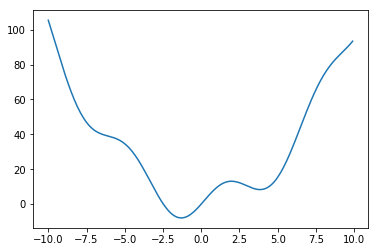

In [27]:
# and plot it:

x = np.arange(-10, 10, 0.1)

plt.plot(x, f(x)) 

plt.show() 

This function has a global minimum around -1.3 and a local minimum around 3.8.

Searching for minimum can be done with scipy.optimize.minimize(), given a starting point x0, it returns the location of the minimum that it has found:

In [28]:
result = optimize.minimize(f, x0=0)
result 

      fun: -7.945823375615215
 hess_inv: array([[0.08589237]])
      jac: array([-1.1920929e-06])
  message: 'Optimization terminated successfully.'
     nfev: 18
      nit: 5
     njev: 6
   status: 0
  success: True
        x: array([-1.30644012])

In [29]:
result.x # The coordinate of the minimum  

array([-1.30644012])

**Methods**: As the function is a smooth function, gradient-descent based methods are good options. The lBFGS algorithm is a good choice in general:

In [30]:
optimize.minimize(f, x0=0, method="L-BFGS-B")  

      fun: array([-7.94582338])
 hess_inv: <1x1 LbfgsInvHessProduct with dtype=float64>
      jac: array([-1.42108547e-06])
  message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
     nfev: 12
      nit: 5
   status: 0
  success: True
        x: array([-1.30644013])

**Note**

Note how it cost only 12 functions evaluation above to find a good value for the minimum.


**Global minimum**: A possible issue with this approach is that, if the function has local minima, the algorithm may find these local minima instead of the global minimum depending on the initial point x0:




In [31]:
res = optimize.minimize(f, x0=3, method="L-BFGS-B")
res.x

array([3.83746709])

If we don’t know the neighborhood of the global minimum to choose the initial point, we need to resort to costlier global optimization. To find the global minimum, we use scipy.optimize.basinhopping() (added in version 0.12.0 of Scipy). It combines a local optimizer with sampling of starting points:


In [32]:
optimize.basinhopping(f, 0) 

                        fun: -7.945823375615284
 lowest_optimization_result:       fun: -7.945823375615284
 hess_inv: array([[0.08584502]])
      jac: array([1.1920929e-07])
  message: 'Optimization terminated successfully.'
     nfev: 15
      nit: 3
     njev: 5
   status: 0
  success: True
        x: array([-1.30644001])
                    message: ['requested number of basinhopping iterations completed successfully']
      minimization_failures: 0
                       nfev: 1533
                        nit: 100
                       njev: 511
                          x: array([-1.30644001])

**Constraints**: We can constrain the variable to the interval (0, 10) using the “bounds” argument:

As minimize() works in general with x multidimensionsal, the “bounds” argument is a list of bound on each dimension.

In [33]:
res = optimize.minimize(f, x0=1, bounds=((0, 10), ))
res.x    

array([0.])

#### Optimization of a two-parameter function

$$
f(x,y) = (4 - 2.1x^2 + \frac {x^4}{3})x^2 + xy + (4y^2 - 4)y^2
$$

In [34]:
import numpy as np


# Define the function that we are interested in
def sixhump(x):
    return ((4 - 2.1*x[0]**2 + x[0]**4 / 3.) * x[0]**2 + x[0] * x[1]
            + (-4 + 4*x[1]**2) * x[1] **2)

# Make a grid to evaluate the function (for plotting)
x = np.linspace(-2, 2)
y = np.linspace(-1, 1)
xg, yg = np.meshgrid(x, y)

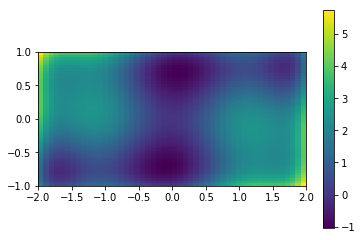

In [35]:
# Simple visualization in 2D

import matplotlib.pyplot as plt
plt.figure()
plt.imshow(sixhump([xg, yg]), extent=[-2, 2, -1, 1])
plt.colorbar()

plt.show()


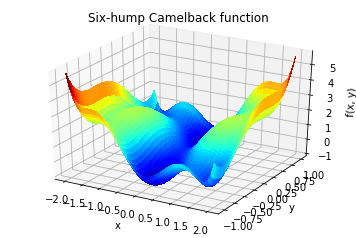

In [36]:
# A 3D surface plot of the function

from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
surf = ax.plot_surface(xg, yg, sixhump([xg, yg]), rstride=1, cstride=1,
                       cmap=plt.cm.jet, linewidth=0, antialiased=False)

ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('f(x, y)')
ax.set_title('Six-hump Camelback function')

plt.show()

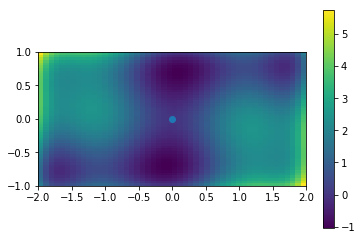

In [37]:
# Find the minima

from scipy import optimize

x_min = optimize.minimize(sixhump, x0=[0, 0])

plt.figure()
# Show the function in 2D
plt.imshow(sixhump([xg, yg]), extent=[-2, 2, -1, 1])
plt.colorbar()
# And the minimum that we've found:
plt.scatter(x_min.x[0], x_min.x[1])

plt.show()

###  Finding the roots of a scalar function

To find a root, i.e. a point where $f(x) = 0$, of the function $f$ above we can use scipy.optimize.root():

In [38]:
root = optimize.root(f, x0=1)  # our initial guess is 1
root

    fjac: array([[-1.]])
     fun: array([0.])
 message: 'The solution converged.'
    nfev: 10
     qtf: array([1.33310463e-32])
       r: array([-10.])
  status: 1
 success: True
       x: array([0.])

In [39]:
root.x  # Only the root found

array([0.])

Note that only one root is found. Inspecting the plot of $f$ reveals that there is a second root around -2.5. We find the exact value of it by adjusting our initial guess:

In [40]:
root2 = optimize.root(f, x0=-2.5)
root2.x

array([-2.47948183])

**Note**

scipy.optimize.root() also comes with a variety of algorithms, set via the “method” argument.

Now that we have found the minima and roots of f and used curve fitting on it, we put all those results together in a single plot:

Global minima found [-1.30641113]
Local minimum found 3.8374671194983834


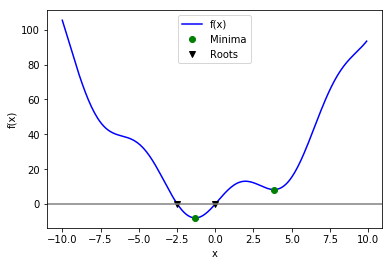

In [41]:
x = np.arange(-10, 10, 0.1)
def f(x):
    return x**2 + 10*np.sin(x)

# Global optimization
grid = (-10, 10, 0.1)
xmin_global = optimize.brute(f, (grid, ))
print("Global minima found %s" % xmin_global)

# Constrain optimization
xmin_local = optimize.fminbound(f, 0, 10)
print("Local minimum found %s" % xmin_local)

fig = plt.figure(figsize=(6, 4))
ax = fig.add_subplot(111)

# Plot the function
ax.plot(x, f(x), 'b-', label="f(x)")

# Plot the minima
xmins = np.array([xmin_global[0], xmin_local])
ax.plot(xmins, f(xmins), 'go', label="Minima")

# Plot the roots
roots = np.array([root.x, root2.x])
ax.plot(roots, f(roots), 'kv', label="Roots")

# Decorate the figure
ax.legend(loc='best')
ax.set_xlabel('x')
ax.set_ylabel('f(x)')
ax.axhline(0, color='gray')

plt.show()

### Statistics and random numbers: scipy.stats

The module scipy.stats contains statistical tools and probabilistic descriptions of random processes. Random number generators for various random process can be found in numpy.random.

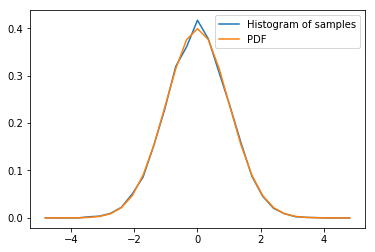

In [44]:
import scipy.stats as stats

samples = np.random.normal(size=10000)

# Compute a histogram of the sample
bins = np.linspace(-5, 5, 30)
histogram, bins = np.histogram(samples, bins=bins, density=True)

bin_centers = 0.5*(bins[1:] + bins[:-1])
pdf = stats.norm.pdf(bin_centers)  # norm is a distribution object

plt.figure(figsize=(6, 4))
plt.plot(bin_centers, histogram, label="Histogram of samples")
plt.plot(bin_centers, pdf, label="PDF")
plt.legend()
plt.show()

In [45]:
loc, std = stats.norm.fit(samples)
loc 

-0.004781545194888013

In [46]:
std  

0.997751925188732

#### Mean, median and percentiles

The mean is an estimator of the center of the distribution:

In [47]:
np.mean(samples)     

-0.004781545194888013

The median another estimator of the center. It is the value with half of the observations below, and half above:
Unlike the mean, the median is not sensitive to the tails of the distribution. It is “robust”.

In [48]:
np.median(samples)

-0.0018165169343191266

In [51]:
samples

array([-0.90633015, -0.36438275, -1.44119407, ...,  1.49098278,
        1.1573592 , -3.58104587])

The median is also the percentile 50, because 50% of the observation are below it:

In [49]:
stats.scoreatpercentile(samples, 50)  

/usr/local/lib/python3.6/dist-packages/scipy/stats/stats.py:1706: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


-0.0018165169343191266

Similarly, we can calculate the percentile 90:

In [52]:
stats.scoreatpercentile(samples, 90)     

1.2719555584074949

The percentile is an estimator of the CDF: cumulative distribution function.

#### Statistical tests

A statistical test is a decision indicator. For instance, if we have two sets of observations, that we assume are generated from Gaussian processes, we can use a T-test to decide whether the means of two sets of observations are significantly different:

In [58]:
a = np.random.normal(0, 1, size=100)
b = np.random.normal(1, 1, size=30)

stats.ttest_ind(a, b)

Ttest_indResult(statistic=-4.475778898964942, pvalue=1.6639255047841456e-05)

The resulting output is composed of:

* The T statistic value: it is a number the sign of which is proportional to the difference between the two random processes and the magnitude is related to the significance of this difference.
* the p value: the probability of both processes being identical. If it is close to 1, the two process are almost certainly identical. The closer it is to zero, the more likely it is that the processes have different means.


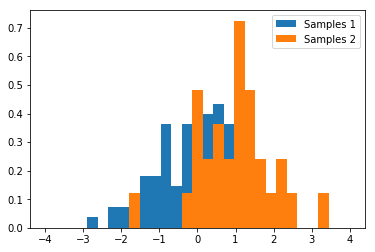

In [59]:
# Compute a histogram of the sample
bins = np.linspace(-4, 4, 30)
histogram1, bins = np.histogram(a, bins=bins, density=True)
histogram2, bins = np.histogram(b, bins=bins, density=True)

plt.figure(figsize=(6, 4))
plt.hist(a, bins=bins, density=True, label="Samples 1")
plt.hist(b, bins=bins, density=True, label="Samples 2")
plt.legend(loc='best')
plt.show()

### Numerical integration: scipy.integrate
##### Function integrals

The most generic integration routine is scipy.integrate.quad(). To compute $\int_0^{\pi / 2} sin(t) dt$:

In [60]:
from scipy.integrate import quad

res, err = quad(np.sin, 0, np.pi/2)

np.allclose(res, 1)   # res is the result, is should be close to 1

True

In [61]:
np.allclose(err, 1 - res)  # err is an estimate of the err

True

Other integration schemes are available: scipy.integrate.fixed_quad(), scipy.integrate.quadrature(), scipy.integrate.romberg()

#### Integrating differential equations

scipy.integrate also features routines for integrating Ordinary Differential Equations (ODE). In particular, scipy.integrate.odeint() solves ODE of the form:

$\frac{dy}{dt} = rhs(y1, y2, .., t0,...)$

As an introduction, let us solve the ODE $\frac{dy}{dt} = -2 y$ between $t = 0 \dots 4$, with the initial condition $y(t=0) = 1$. First the function computing the derivative of the position needs to be defined:

In [62]:
def calc_derivative(ypos, time):
    return -2 * ypos

Then, to compute y as a function of time:

In [63]:
from scipy.integrate import odeint

time_vec = np.linspace(0, 4, 40)
y = odeint(calc_derivative, y0=1, t=time_vec)

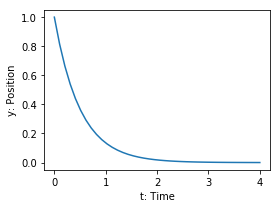

In [64]:
plt.figure(figsize=(4, 3))
plt.plot(time_vec, y)
plt.xlabel('t: Time')
plt.ylabel('y: Position')
plt.tight_layout()

Let us integrate a more complex ODE: a damped spring-mass oscillator. The position of a mass attached to a spring obeys the 2nd order ODE $y'' + 2 \varepsilon \omega_0 y' + \omega_0^2 y = 0$ with $\omega_0^2 = k/m$ with $k$ the spring constant, $m$ the mass and $\varepsilon = c/(2 m \omega_0)$ with $c$ the damping coefficient. We set:

In [65]:
mass = 0.5  # kg
kspring = 4  # N/m
cviscous = 0.4  # N s/m

In [66]:
# Hence:

eps = cviscous / (2 * mass * np.sqrt(kspring/mass))
omega = np.sqrt(kspring / mass)

# The system is underdamped, as:
eps < 1

True

For odeint(), the 2nd order equation needs to be transformed in a system of two first-order equations for the vector $Y = (y, y')$: the function computes the velocity and acceleration:


In [67]:
def calc_deri(yvec, time, eps, omega):
    return (yvec[1], -eps * omega * yvec[1] - omega **2 * yvec[0])

Integration of the system follows:

In [68]:
time_vec = np.linspace(0, 10, 100)
yinit = (1, 0)
yarr = odeint(calc_deri, yinit, time_vec, args=(eps, omega))

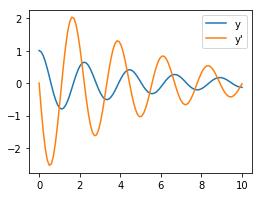

In [69]:
plt.figure(figsize=(4, 3))
plt.plot(time_vec, yarr[:, 0], label='y')
plt.plot(time_vec, yarr[:, 1], label="y'")
plt.legend(loc='best')
plt.show()

scipy.integrate.odeint() uses the LSODA (Livermore Solver for Ordinary Differential equations with Automatic method switching for stiff and non-stiff problems), see the ODEPACK Fortran library for more details.

**Note**

There is no Partial Differential Equations (PDE) solver in Scipy. Some Python packages for solving PDE’s are available, such as fipy or SfePy.